In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
fr = session.query(Measurement).first()
print(fr.__dict__)

# fr = session.query(Station).first()
# print(fr.__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x7fc49049acc0>, 'prcp': 0.08, 'station': 'USC00519397', 'tobs': 65.0, 'date': '2010-01-01', 'id': 1}


In [10]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [50]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
# print("12 months before most recent measurement: ",year_ago)


# Perform a query to retrieve the data and precipitation scores
most_recent = dt.date(2017,8,23)

date_list = [year_ago + dt.timedelta(n) for n in range(int((most_recent - year_ago).days))] # get dates in range
date_list_format = [x.strftime("%Y-%m-%d") for x in date_list]
date_list_format.sort()

date_list_format = list(set(date_list_format)) # get unique values

date_rows = []

for date in date_list_format:
    if len(session.query(Measurement).filter(Measurement.date == date).all()) > 0:
        rows = session.query(Measurement).filter(Measurement.date == date).all()
        for r in rows:
            date_rows.append(tuple([r.prcp,r.station,r.tobs,date,r.id]))


In [55]:
# Save the query results as a Pandas DataFrame and set the index to the date column
date_rows_df = pd.DataFrame(date_rows, columns=["Prcp","Station","TOBS","Date","ID"])

# Sort the dataframe by date
date_rows_df = date_rows_df.sort_values(by="Date")
date_rows_df.head()

,Prcp,Station,TOBS,Date,ID
2027,0.00,USC00519397,81.0,2016-08-23,2364
2031,0.02,USC00519523,80.0,2016-08-23,11851
2032,1.79,USC00519281,77.0,2016-08-23,14608
2033,0.70,USC00516128,74.0,2016-08-23,19202
2028,0.15,USC00513117,76.0,2016-08-23,5091


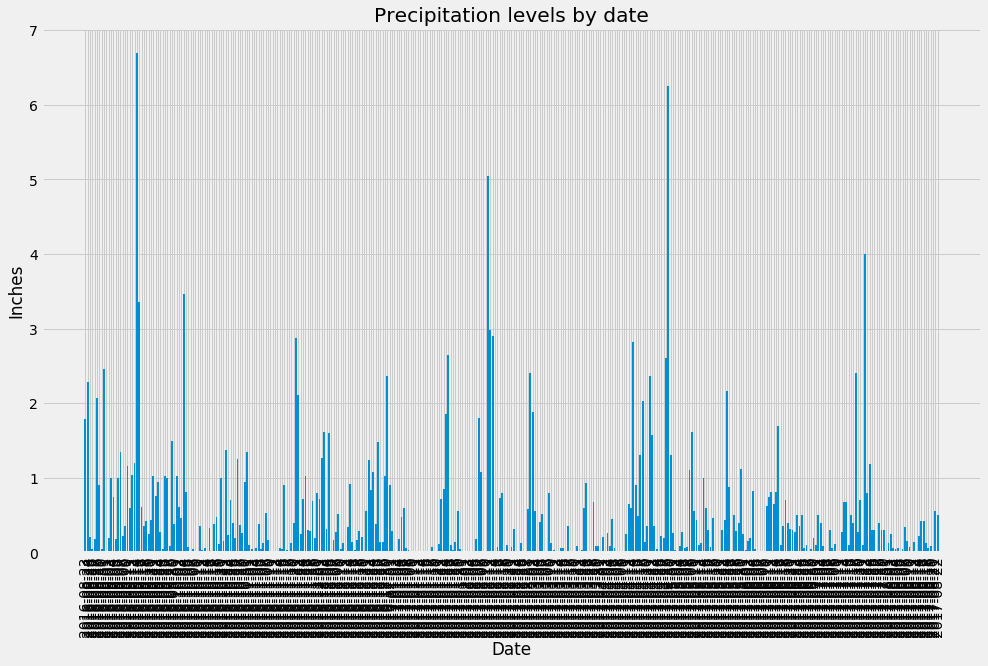

In [69]:
# Use Pandas Plotting with Matplotlib to plot the data
date_rows_avg = date_rows_df.groupby("Date").max()
# date_rows_avg.head()

plt.figure(figsize=(15,9))
plt.bar(date_rows_avg.index,date_rows_avg["Prcp"])
plt.ylabel("Inches")
plt.title("Precipitation levels by date")
plt.xlabel("Date")
plt.xticks(rotation = 90)
plt.show()

In [72]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_rows_df["Prcp"].describe()

count    2017.000000
mean        0.177367
std         0.461568
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Prcp, dtype: float64

# Exploratory Station Analysis

In [74]:
# Design a query to calculate the total number stations in the dataset
# fr = session.query(Station).first()
# print(fr.__dict__)

session.query(func.count(Station.station)).all()

[(9)]

In [78]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [85]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

lowest = session.query(Measurement.tobs, func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
print("The lowest temperature for Station USC00519281: ",lowest[0][0])

highest = session.query(Measurement.tobs, func.max(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
print("The highest temperature for Station USC00519281: ",highest[0][0])

avg = session.query(Measurement.tobs, func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
print("The average temperature for Station USC00519281: ",avg[0][0])

The lowest temperature for Station USC00519281:  54.0
The highest temperature for Station USC00519281:  85.0
The average temperature for Station USC00519281:  70.0


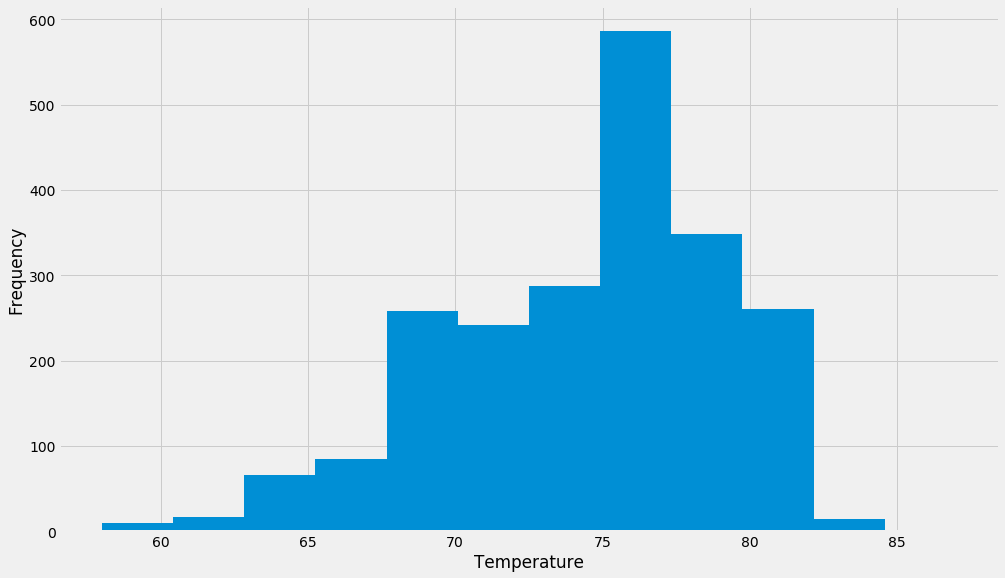

In [89]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_rows = []

for date in date_list_format:
    if len(session.query(Measurement).filter(Measurement.station == 'USC00519281').filter(Measurement.date == date).all()) > 0:
        rows = session.query(Measurement).filter(Measurement.date == date).all()
        for r in rows:
            station_rows.append(tuple([r.prcp,r.station,r.tobs,date,r.id]))


station_rows_df = pd.DataFrame(station_rows, columns=["Prcp","Station","TOBS","Date","ID"])


# Plotting histogram
plt.figure(figsize=(15,9))
plt.hist(station_rows_df["TOBS"],bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close session

In [90]:
# Close Session
session.close()